In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import time

In [2]:
data_pathEM = glob('FXEM_data/*.csv') #пути для данных
data_pathDM = glob('testData/*.csv')

dataset = []
names = list()

if len(data_pathEM) >= 1:
    for file in data_pathEM[:1]: # подготавливаем данные
        row = pd.read_csv(file, index_col=0)
        row = row.reset_index()
        row = row.drop(row.columns[[0,6,7,8]], axis=1) # убираем ненужное
        row.time = pd.to_datetime(row.time)
        row['Date'], row['Time'] = row['time'].dt.normalize(), row['time'].dt.time # разделяю дату и время
        row = row.set_index('time')
        dataset.append(row)
        names.append(file.split('\\')[1][:-4]) # добавляем название пары

if len(data_pathDM) >= 1:
    for file in data_pathDM[:1]:
        row = pd.read_csv(file, index_col=0)
        row = row.reset_index()
        row.time = pd.to_datetime(row.time)
        row['Date'], row['Time'] = row['time'].dt.normalize(), row['time'].dt.time
        row = row.set_index('time')
        dataset.append(row)
        names.append(file.split('/')[1][:-4])

def Date_change(df): # сбор индексов изменения даты и списка дат
    """
    Makes a list of indexes of new dates for Strategy Statistics.
    :param df: dataframe
    """
    date_indexes = []
    date_indexes.append(0)
    Dates = tuple(df.Date.values)
    for i in range(0,len(Dates)-2):
        if Dates[i] != Dates[i+1]:
            date_indexes.append(i+1)
    return date_indexes

dates_inset = []
dates_outset = []
inset = [] # in sample data
outset = [] # out of sample data
for i in range(0,len(dataset)): # разделение на семплы

    insample = dataset[i].loc['2019-01-02 03:00:00':'2020-01-02 03:00:00']
    insample = insample.reset_index()
    dates = Date_change(insample)
    dates_inset.append(dates)
    inset.append(insample)

    outsample = dataset[i].loc['2020-01-02 03:00:00': '2021-01-04 01:15:00']
    outsample = outsample.reset_index()
    dates = Date_change(outsample)
    dates_outset.append(dates)
    outset.append(outsample)

In [3]:
def bollinger_bands(df, X, Y):
    """
    Adds Bollinger Bands to dataframe of FX-pair

    :param df: initial dataframe
    :param X: period of MA and STD (in minutes)
    :param Y: threshold (in % form STD)
    :return: dataframe with MA, STD and Bollinger Bands
    """

    df.loc[:, 'MA'] = df.loc[:, 'close'].rolling(X).mean()
    df.loc[:, 'STD'] = df.loc[:, 'close'].rolling(X).std()
    df.loc[:, 'HBB'] = df.loc[:, 'MA'] + ((Y / 100) * df.loc[:, 'STD'])
    df.loc[:, 'LBB'] = df.loc[:, 'MA'] - ((Y / 100) * df.loc[:, 'STD'])

    return df

def tuple_preprocessing(df,X):
    """
    Cuts and translates all necessary data to tuples (for speed)

    :param df: initial dataframe
    :param X: period of MA and STD (in minutes)
    :return: tuple_dataset of tuples with values from dataframe
    """

    tuple_dataset = tuple(map(
        lambda df : tuple(df.values[X:]),
        (df.Date, df.close, df.high, df.low, df.MA, df.HBB, df.LBB)
    ))

    return tuple_dataset

def data_preparation(df,X,Y):
    """
    Full data preparation for strategy running.
    td is for tuple_dataset
    """
    df = bollinger_bands(df, X, Y)
    td = tuple_preprocessing(df, X)

    date, close, high, low, MA, HBB, LBB = td[0], td[1], td[2], td[3], td[4], td[5], td[6]

    return date, close, high, low, MA, HBB, LBB


def Open_trade(index, Overflow_counter, high, low, HBB, LBB, end):
    """
    Recursively finds a place of Trade opening

    :param index: start
    :param Overflow_counter: counts shots of recursion (preventing StackOverflowError)
    :param high, low: highs and lows tuples from price bars
    :param HBB, LBB: Higher and Lower Bollinger Band tuples
    :param end: length of tuples
    :return: index, Trade index - place and type of trade
    """
    if (index >= end-1) or (Overflow_counter == 2998):
        Trade_index = 0
        return index, Trade_index

    elif low[index] <= LBB[index]:
        Trade_index = 1
        return index, Trade_index

    elif high[index] >= HBB[index]:
        Trade_index = -1
        return index, Trade_index

    else:
        return Open_trade(index+1, Overflow_counter+1, high, low, HBB, LBB, end)

def LongLVL_calculator(index, LBB, TP, SL):
    """
    Calculates the bounds of Stop Loss and Take Profit in $ for Long Trade

    :param index: start (often is index of open trade)
    :param LBB: Lower Bollinger Band tuple
    :param TP: Take Profit (in %)
    :param SL: Stop Loss (in %)
    """
    Open_price = LBB[index]
    TP_lvl = Open_price * (1 + TP / 100)
    SL_lvl = Open_price * (1 - SL / 100)
    return Open_price, TP_lvl, SL_lvl


def ShortLVL_calculator(index, HBB, TP, SL):
    """
    Calculates the bounds of Stop Loss and Take Profit in $ for Short Trade

    :param index: start (often is index of open trade)
    :param HBB: Higher Bollinger Band tuple
    :param TP: Take Profit (in %)
    :param SL: Stop Loss (in %)
    """
    Open_price = HBB[index]
    TP_lvl = Open_price * (1 - TP / 100)
    SL_lvl = Open_price * (1 + SL / 100)
    return Open_price, TP_lvl, SL_lvl

def Close_long(index, Time_counter, close, high, low, TC, TP_lvl, SL_lvl, end):
    """
    Recursively finds a place of closing Long trade.
    Max Time Close is 3000 minutes (restricted because of StackOverflowError)

    :param index: start (often is index of open trade +1)
    :param Time_counter: for comparing with Time Close
    :param close, high, low: tuples from price bars
    :param TC: Time Close (in minutes)
    :param TP_lvl: Price level of Take Profit
    :param SL_lvl: Price level of Stop Loss
    :param end: length of tuples
    :return: index, Trade index - place and type of trade
    """

    if (index >= end-1) or (Time_counter == TC):
        Trade_index = 3
        return index, Trade_index

    elif low[index] <= SL_lvl:
        Trade_index = -2
        return index, Trade_index

    elif high[index] >= TP_lvl:
        Trade_index = 2
        return index, Trade_index

    else:
        return Close_long(index+1, Time_counter+1, close, high, low, TC, TP_lvl, SL_lvl, end)

def Close_short(index, Time_counter, close, high, low, TC, TP_lvl, SL_lvl, end):
    """
    Recursively finds a place of closing Short trade.
    Max Time Close is 3000 minutes (restricted because of StackOverflowError)

    :param index: start (often is index of open trade +1)
    :param Time_counter: for comparing with Time Close
    :param close, high, low: tuples from price bars
    :param TC: Time Close (in minutes)
    :param TP_lvl: Price level of Take Profit
    :param SL_lvl: Price level of Stop Loss
    :param end: length of tuples
    :return: index, Trade index - place and type of trade
    """

    if (index >= end-1) or (Time_counter == TC):
        Trade_index = 3
        return index, Trade_index

    elif high[index] >= SL_lvl:
        Trade_index = -2
        return index, Trade_index

    elif low[index] <= TP_lvl:
        Trade_index = 2
        return index, Trade_index

    else:
        return Close_short(index+1, Time_counter+1, close, high, low, TC, TP_lvl, SL_lvl, end)

def Return_calculator(index, Trade_index, Open_price, close, TP_lvl, SL_lvl):
    """
    Calculates clear Return by type of Trade Close
    (return from short trade should be inverted)
    """

    if Trade_index == 3:
        Close_price = close[index]
        Return = Close_price - Open_price
    elif Trade_index == 2:
        Close_price = TP_lvl
        Return = Close_price - Open_price
    elif Trade_index == -2:
        Close_price = SL_lvl
        Return = Close_price - Open_price
    else:
        Return = 0
    return Return

def Strategy_logic(df, X, Y, TC, TP, SL, slpg):
    """
    Makes list of Trades and Returns according to rules of strategy.
    Max Time Close is 3000 minutes (restricted because of StackOverflowError)
    Every calculation is removed from recursive functions for productivity

    :param df: initial dataframe
    :param X: period of MA and STD (in minutes)
    :param Y: threshold (in % form STD)
    :param TC: Time Close (in minutes) - 3000 is maximum
    :param TP: Take Profit (in %)
    :param SL: Stop Loss (in %)
    :param slpg: Slippage (in $)
    """

    # preparing data and lists for filling
    date, close, high, low, MA, HBB, LBB = data_preparation(df, X, Y)
    end = len(date)
    Return_List = np.zeros(end)
    TradeIndex_List = np.zeros(end)
    index = 0

    while index < end-1:

        Overflow_counter = 0

        # searching for open trade
        index, Trade_index = Open_trade(
            index, Overflow_counter, high, low, HBB, LBB, end
        )

        TradeIndex_List[index] = Trade_index

        # long trade
        if Trade_index == 1:

            Open_price, TP_lvl, SL_lvl = LongLVL_calculator(index, LBB, TP, SL)

            Time_counter = 0

            index, Trade_index = Close_long(
                index+1, Time_counter, close, high, low, TC, TP_lvl, SL_lvl, end
            )

            TradeIndex_List[index] = Trade_index
            Return = Return_calculator(
                index, Trade_index, Open_price, close, TP_lvl, SL_lvl
            )

            Return_List[index] = Return - slpg

        # short trade
        elif Trade_index == -1:
            Open_price, TP_lvl, SL_lvl = ShortLVL_calculator(index, HBB, TP, SL)

            Time_counter = 0

            index, Trade_index = Close_short(
                index+1, Time_counter, close, high, low, TC, TP_lvl, SL_lvl, end
            )

            TradeIndex_List[index] = Trade_index

            Return = Return_calculator(
                index, Trade_index, Open_price, close, TP_lvl, SL_lvl
            )

            Return_List[index] = - Return - slpg # different return for short

        else:
            pass # if there was no open trade, then the process of Opening trade repeats from new index

    return Return_List, TradeIndex_List

def Returns_resampler(Return_List, date_indexes):  # суммирование всех доходов по каждому дню
    """
    Resamples returns by trading days
    """

    norm_rets = []
    for i in range(0,len(date_indexes)-1):
        ret = 0
        for k in range(date_indexes[i], date_indexes[i+1]):
            ret = ret + Return_List[k]
        norm_rets.append(ret)
    return norm_rets


def Optimisation_Stats(date_indexes, Return_List, period):
    """
    Metrics for optimisation
    :param period: period for Sharpe Ratio
    :return: Sharpe Ratio, PNL/MDD
    """

    norm_rets = Returns_resampler(Return_List, date_indexes)
    days_run = len(norm_rets)
    PNL = np.cumsum(norm_rets)
    Total_PNL = np.sum(norm_rets)
    AVG = Total_PNL/days_run
    STD = np.std(norm_rets)
    SR = np.sqrt(period) * AVG / STD

    # Total_PNL/MDD
    MDD = 0
    for i in range(2,len(PNL)-1): # cumulative max and min of PNL
        current_max = np.max(PNL[:i])
        following_min = np.min(PNL[i:])
        current_DD = current_max - following_min
        if  current_DD > MDD:
            MDD = current_DD
    PDD = Total_PNL / MDD

    return SR, PNL, PDD

def Trades_Stats_collector(Return_List, TradeIndex_List):
    """
    Counts numbers of trades of different types
    """
    long = short = win = loss = take = stop = time_close = 0

    for element in TradeIndex_List:
        if element == 0: pass
        elif element == 1: long = long+1
        elif element == -1: short = short+1
        elif element == 2: take = take+1
        elif element == -2: stop = stop+1
        elif element == 3: time_close = time_close+1
        else: pass

    for Return in Return_List:
        if Return == 0: pass
        elif Return < 0: loss = loss+1
        elif Return > 0: win = win+1
        else: pass

    return long, short, win, loss, take, stop, time_close

In [4]:
inset
names

['AUDCAD']

0.3610374469999993
0.5438803279999984
0.6172683279999998
long = 483, short = 458, win = 510, loss = 431, take = 1, stop = 0, time_close = 741


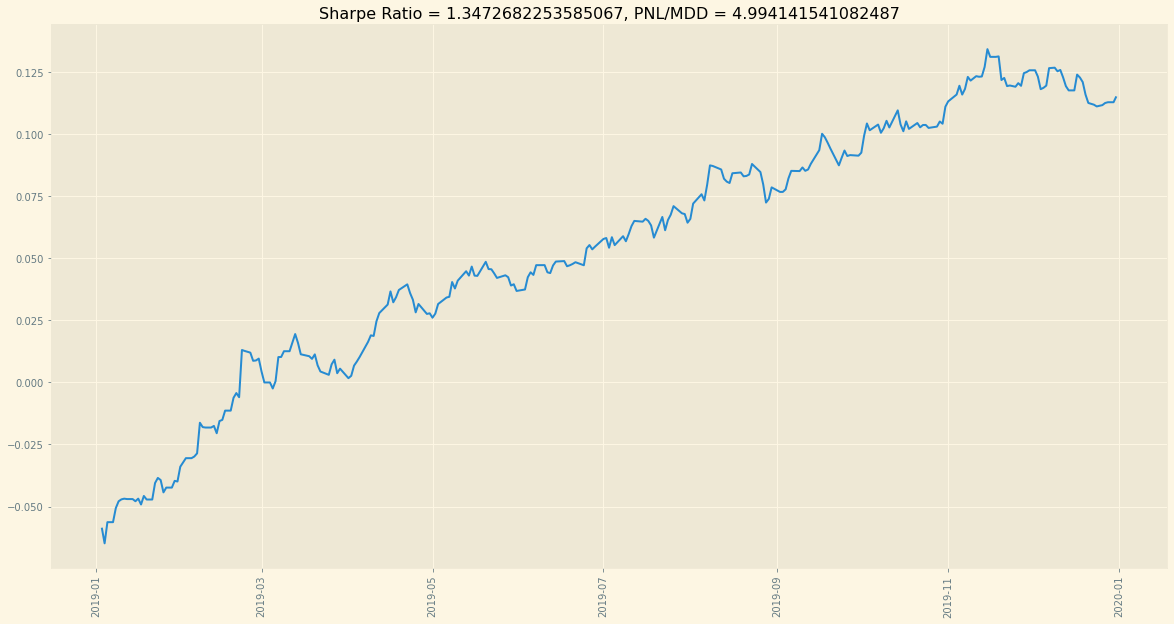

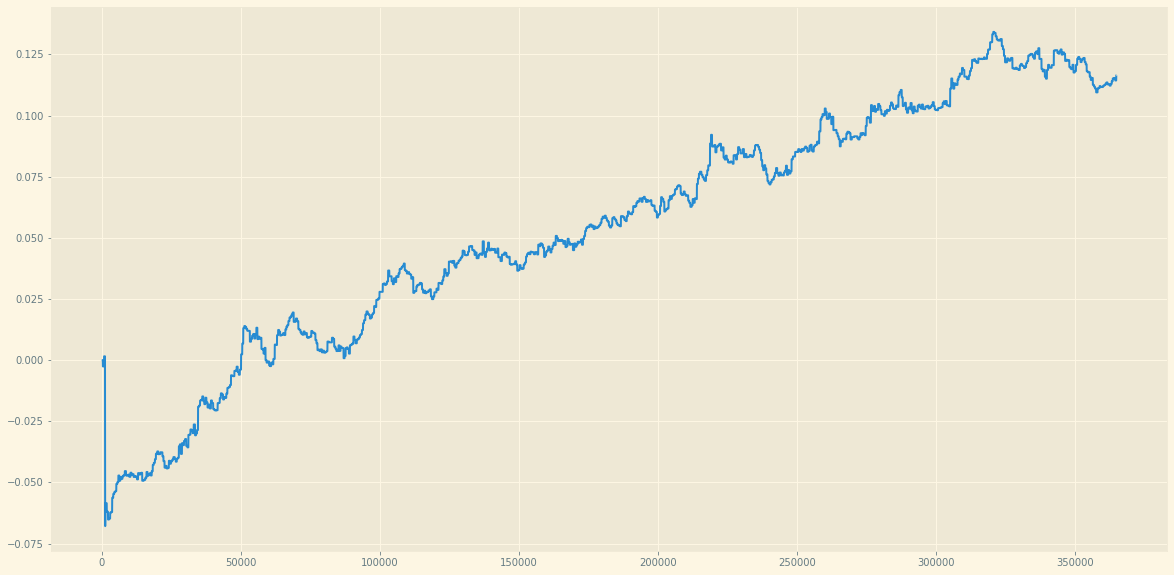

In [5]:
df = inset[0].copy()

date_indexes = dates_inset[0]
dates = df.Date.values
dates_list = [dates[index] for index in date_indexes]
del dates_list[0]

Time = time.monotonic()
rets, trades = Strategy_logic(df, 120, 200, 360, 1, 1, 0)
print(time.monotonic() -Time)
long, short, win, loss, take, stop, time_close = Trades_Stats_collector(rets, trades)
print(time.monotonic() - Time)
SR, PNL, PDD = Optimisation_Stats(date_indexes, rets, 255)
print(time.monotonic() - Time)

pnl = np.cumsum(rets)

plt.style.use('Solarize_Light2')
plt.figure(figsize=(20, 10))
plt.plot(dates_list, PNL)
plt.title(f"Sharpe Ratio = {SR}, PNL/MDD = {PDD}")
plt.xticks(rotation = 90)
plt.show()

print(f'long = {long}, short = {short}, '
      f'win = {win}, loss = {loss}, '
      f'take = {take}, stop = {stop}, time_close = {time_close}')

plt.style.use('Solarize_Light2')
plt.figure(figsize=(20, 10))
plt.plot(pnl)
plt.show()

In [6]:
trades

array([1., 0., 0., ..., 0., 0., 0.])